# Assignment 1

In the first assignment, you will implement some of the algorithms you have learnt in the first two weeks of lectures: n-gram language models, and syntactic parsing using the CYK algorithm. 

# Setup

For this and other assignments, we will be using Google Colab, for both code as well as descriptive questions. Your task is to finish all the questions in the Colab notebook and then upload a PDF version of the notebook, and a viewable link on Gradescope.

### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people.

### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write / change / uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected. Copy the link and paste it in the box below.
5. After completing the notebook, press __File > Download .ipynb__ to download a local copy on your computer, and then upload the file to Gradescope.


__Paste your notebook link in the box below.__ _(0 points)_



```
# Paste your Colab notebook link here
```
https://colab.research.google.com/drive/1DsHSWALT7cbvDwyNm38dFXZnNv92H1JQ#scrollTo=inEvaul0l3GR



In [1]:
# Downloads required packages and files
required_files = "https://github.com/jhu-intro-hlt/jhu-intro-hlt.github.io/raw/master/assignments/hw1-files/student/required_files.zip"
! wget $required_files && unzip -o required_files.zip
! pip install -r requirements.txt

--2022-09-22 08:58:33--  https://github.com/jhu-intro-hlt/jhu-intro-hlt.github.io/raw/master/assignments/hw1-files/student/required_files.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jhu-intro-hlt/jhu-intro-hlt.github.io/master/assignments/hw1-files/student/required_files.zip [following]
--2022-09-22 08:58:33--  https://raw.githubusercontent.com/jhu-intro-hlt/jhu-intro-hlt.github.io/master/assignments/hw1-files/student/required_files.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8207 (8.0K) [application/zip]
Saving to: ‘required_files.zip’

required_files.zip  100%[=================

     |████████████████████████████████| 115 kB 18.6 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 19.9 MB/s eta 0:00:01


     |████████████████████████████████| 211 kB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 3.1 MB 26.2 MB/s eta 0:00:01
  Created wheel for datascience: filename=datascience-0.17.5-py3-none-any.whl size=732527 sha256=180e013a0f9d09df8015e21abcc2a9485450f25f8b33d2571b59cc0a75278d49
  Stored in directory: /Users/meililiu/Library/Caches/pip/wheels/e3/ae/e2/6f3b97f28aed25dcfaa2cf9af603c70018d9598e24f1240248
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=8a90f15f882ec0cbafc7ca490db90e1caf716c32733a3a2c515592230a23f9fa
  Stored in directory: /Users/meililiu/Library/Caches/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built datascience sklearn
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typi

In [2]:
# Initialize Otter
import otter
grader = otter.Notebook(colab=True)

In [3]:
import random
import math
import re
import os
import urllib
import json
from typing import *
from collections import Counter, defaultdict

import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer, sent_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/meililiu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Part 1: N-gram Language Models

For the first part of this assignment, you will implement a trigram language model and train it on a small corpus. You will then implement a scoring function to compute the perplexity of the model on a held-out test set. Finally, you will implement some methods to deal with sparsity (zero count) issues in your model.

To ease you into the implementation, we will provide some boilerplate code that you would need to fill in depending upon the functionalities the code is supposed to perform. For the first few sections below, we will use the complete text from Leo Tolstoy's "War and Peace," which is freely available from [Project Gutenberg](https://www.gutenberg.org/). Run the following code block to download the text. 

In [4]:
def download_data():
    def _download(url: str, filename: str) -> str:
        txt = urllib.request.urlopen(url)
        with open(filename, 'w') as f:
            f.write(txt.read().decode('utf-8'))
        
    _download('https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt', 'warpeace_input.txt')
    _download('http://www.gutenberg.org/files/1399/1399-0.txt', '1399-0.txt')

download_data()

The complete text downloaded above contains punctuations which are not important for our purposes. So we will perform a basic text preprocessing using the [NLTK toolkit](https://www.nltk.org/). We will store the processed text into a list of strings, where each string will contain words without any punctuations. We will also convert all words to lower case.

In [5]:
# Loading the text
try:
    with open('warpeace_input.txt', 'r') as file:
        corpus_raw = file.read().replace('\n', ' ')
except FileNotFoundError:
    with open('../../warpeace_input.txt', 'r') as file:
        corpus_raw = file.read().replace('\n', ' ')

In [6]:
sentences = sent_tokenize(corpus_raw)

corpus = []
tokenizer = RegexpTokenizer(r'\w+')
for sentence in sentences:
    tokens = tokenizer.tokenize(sentence)
    corpus.append([token.lower() for token in tokens])

print("Corpus has {} sentences".format(len(corpus)))

Corpus has 32040 sentences


### Warm-up: n-gram counts from a corpus

Let's start with implementing a simple function for obtaining n-grams and their counts from a string. Complete the following function. _(5 points)_

__Note 1:__ Use the special token `~` for both beginning of sentence (BOS) and end of sentence (EOS) tokens. For example, the sentence "Mary has a little lamb" has the bigrams "_~ Mary_", "_Mary has_", "_has a_", "_a little_", "_little lamb_", and "_lamb ~_".

__Note 2:__ You don't need to do any further text processing beyond what has already been done before.

__Note 3:__ For the usage of `collections.Counter`, you can refer to [its python doc](https://docs.python.org/3/library/collections.html#collections.Counter).

In [7]:
def generate_ngrams(text: List[str], n: int) -> Counter:
    """Generates all n-grams (i.e. n-1 context words) for the given text.

    Parameters
    ----------
    text : List[str]
        Input text (list of strings) after tokenization.
    n : int
        n-gram parameter (must be greater than or equal to 1).

    Returns
    -------
    ngrams : Counter
        Output n-grams dictionary as {ngram: count} (Dict[Tuple, int]), 
        where `ngram` is a n-gram tuple and `count` is an integer count.
        e.g. ('Mary','has') and value as count of the n-gram in the text.
    """
    assert (isinstance(n, int) and n > 0)

    ngrams = Counter()

    # TODO: Your code here.
    # iterate through all ngrams and count
    
   
    queue=['~']*n
    for i in range(len(text)+n-1):
      word = text[i] if i < len(text) else "~"
      queue.pop(0)
      queue.append(word)
      ngrams[tuple(queue)]+=1

    return ngrams


def generate_ngrams_sentences(text: List[List[str]], n: int) -> Counter:
    """Generates n-grams for each sentence and aggregates them."""
    all_ngrams = Counter()
    for sentence in text:
        all_ngrams.update(generate_ngrams(sentence, n))
    return all_ngrams

In [8]:
# Test your implementation on some sentences from the corpus we downloaded above
# and verify if it works correctly.
text = corpus[:2]
print(text)

ngrams = generate_ngrams_sentences(text, 3)
print(ngrams)
print(len(ngrams))

[['well', 'prince', 'so', 'genoa', 'and', 'lucca', 'are', 'now', 'just', 'family', 'estates', 'of', 'the', 'buonapartes'], ['but', 'i', 'warn', 'you', 'if', 'you', 'don', 't', 'tell', 'me', 'that', 'this', 'means', 'war', 'if', 'you', 'still', 'try', 'to', 'defend', 'the', 'infamies', 'and', 'horrors', 'perpetrated', 'by', 'that', 'antichrist', 'i', 'really', 'believe', 'he', 'is', 'antichrist', 'i', 'will', 'have', 'nothing', 'more', 'to', 'do', 'with', 'you', 'and', 'you', 'are', 'no', 'longer', 'my', 'friend', 'no', 'longer', 'my', 'faithful', 'slave', 'as', 'you', 'call', 'yourself']]
Counter({('no', 'longer', 'my'): 2, ('~', '~', 'well'): 1, ('~', 'well', 'prince'): 1, ('well', 'prince', 'so'): 1, ('prince', 'so', 'genoa'): 1, ('so', 'genoa', 'and'): 1, ('genoa', 'and', 'lucca'): 1, ('and', 'lucca', 'are'): 1, ('lucca', 'are', 'now'): 1, ('are', 'now', 'just'): 1, ('now', 'just', 'family'): 1, ('just', 'family', 'estates'): 1, ('family', 'estates', 'of'): 1, ('estates', 'of', 'the

In [9]:
grader.check("warmup-ngram")

warmup-ngram results: All test cases passed!

<!-- BEGIN QUESTION -->

__Question:__ Plot a histogram of counts vs. number of unigrams with that count (you can choose a subset of the corpus, say 500 sentences). Repeat for bigrams and trigrams. They should be all placed into a single plot. _(3 points)_

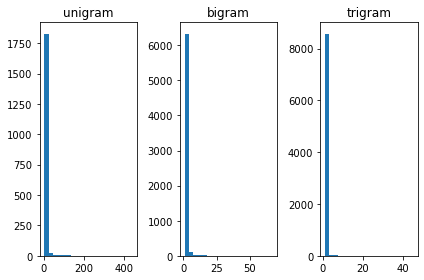

In [131]:
fig, axs = plt.subplots(1, 3, tight_layout=True)

# Picks a subset of the corpus
# TODO: Your code here

text = corpus[:500]
# Unigram counts
# TODO: Your code here

unigram = generate_ngrams_sentences(text, 1)
axs[0].hist(unigram.values(),20)
axs[0].set_title('unigram')
# Bigram counts
# TODO: Your code here
bigram = generate_ngrams_sentences(text, 2)
axs[1].hist(bigram.values(),20)
axs[1].set_title('bigram')
# Trigram counts
# TODO: Your code here
trigram = generate_ngrams_sentences(text, 3)
axs[2].hist(trigram.values(),20)
axs[2].set_title('trigram')
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ What observation can you make from the plots? _(2 points)_

__Answer:__

First, we can see the sparsity in the Ngram model, which means that most elements appear only a few times.
Second, the sparsity becomes larger as n increases.

<!-- END QUESTION -->

### Implementing an n-gram language model

Next, you will implement a class for an trigram (n=3) language model. This will be a barebones trigram LM, i.e., no smoothing or OOV handling is required. Complete
the functions in the following `NgramLM` class. _(20 points)_

Note that the class itself is
for a general n-gram LM, but we will instantiate it with n=3.

_Type your answer here, replacing this text._

In [248]:
class NgramLM(object):
    """A basic n-gram language model without any smoothing."""

    def __init__(self, n: int):
        assert (isinstance(n, int) and n > 0)
        
        self.n: int = n
        self.vocab: Set[str] = set()  # A set of all words appearing in the corpus.
        self.ngrams = Counter()  # count(ABC) - Dict[Tuple, int]
        self.ngram_contexts = Counter()  # count(AB) - Dict[Tuple, int]
        self.contexts = defaultdict(set)  # {AB: {C1,C2,C2}} - Dict[Tuple, Set[str]]
        
    def generate_ngrams(self, text: List[str]) -> Counter:
        """Generates all n-grams (i.e. n-1 context words) for the given text.
        In this method, we assume n is defined at the class initialization,
        so you should use `self.n`.

        Parameters
        ----------
        text : List[str]
            Input text (list of strings) after tokenization.

        Returns
        -------
        ngrams : Counter
            Output n-grams dictionary as {ngram: count} (Dict[Tuple, int]), 
            where `ngram` is a n-gram tuple and `count` is an integer count.
            e.g. ('Mary','has') and value as count of the n-gram in the text.
        """
        return generate_ngrams(text, self.n)
    
    def generate_ngrams_sentences(self, text: List[List[str]]) -> Counter:
        """Generates n-grams for each sentence and aggregates them."""
        return generate_ngrams_sentences(text, self.n)

    def generate_contexts(self,text: List[str]) -> defaultdict(set):
        """ Generate context """
        #print(text)
        context = defaultdict(set)
        queue=['~']*self.n
        for i in range(len(text)+self.n-1):
          word = text[i] if i < len(text) else "~"
          queue.pop(0)
          context[tuple(queue)].add(word)
          queue.append(word)

        return context

    def update(self, text: List[str]):
        """Updates the model n-grams based on the given text input.
        
        Parameters
        ----------
        text : List[str]
        """
        # TODO: Your code here
        #update ngrams

        #get the new ngram from the next text
        new_ngram = self.generate_ngrams(text)
        self.ngrams.update(new_ngram)

        #from the new ngram, uodate contexts and vocab
        for ng,count in new_ngram.items():
          context = ng[:-1]
          word = ng[-1]
          self.ngram_contexts[context]+=count
          self.contexts[context].add(word)
          self.vocab.add(word)
  

    def word_prob(self, context: Tuple[str], word: str) -> float:
        """Returns the probability of a word given a context. The context is a
        string of words, with length n-1. 
        
        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
        word : str
            The next word that the probability is computed for.
            
        Returns
        -------
        prob : float
            The estimated probability of the next word given the context.
        """
        # TODO: Your code here
        triwords = context+tuple([word])
        count_context = self.ngram_contexts[context]
        count_word = self.ngrams[triwords]
        if count_context ==0:
          return 0
        else:
          return float(count_word/count_context)
        
    def next_word_candidates(self, context: Tuple[str]) -> List[str]:
        """Generates a list of tokens based on the given context, which would be
        later used as candidates for the next word prediction.
        
        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
            
        Returns
        -------
        words : List[str]
            A list of candidate tokens for the next word.
        """
        # TODO: Your code here
        #print(list(self.contexts[context]))
        return list(self.contexts[context])

    def random_word(self, context: Tuple[str]) -> str:
        """Generates a random word based on the given context.
        
        Note: 
        Please use a random function from `random` instead of `numpy`;
        otherwise, the autograder might not be happy.
        
        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
            
        Returns
        -------
        word : str
            One randomly drawn word from the distribution defined given the context.
        """
        assert context in self.contexts, f'Encountered unseen context={context}.'
        
        # TODO: Your code here
        candidates = self.next_word_candidates(context)
        weights = [self.word_prob(context,cand) for cand in candidates]
        #rand = random.randint(0,len(candidates)-1)
        randword = random.choices(candidates,weights = weights,k=1)[0]
        return randword

    def random_text(self, length: int) -> List[str]:
        """Generates random text of the specified word length excluding "~" (BOS).
        
        Note: 
        - The final word of the generated text *can* be "~" (EOS), but it is not necessary.
        - The generation should always start with "~" (BOS).
        - Only the number of starting "~" (BOS) is excluded from the generation, any 
        ending "~" (EOS) is still counted to the `length`. It means that you should 
        draw a number of `length` samples.
        
        Note: 
        Please use a random function from `random` instead of `numpy`;
        otherwise, the autograder might not be happy.
        
        Parameters
        ----------
        length : int
            The designated length to generate.
        
        """
        # TODO: Your code here
        context = ["~"]*(self.n-1)
        sentence = []
        sen_len = 0
        while sen_len < length:
          #get next word
          next_word = self.random_word(tuple(context))
          #append the next word to the sentence
          #sentence = sentence +" "+next_word
          sentence.append(next_word)
          #update the context
          context.append(next_word)
          context.pop(0)

          #update the length of sentecne
          sen_len += 1
        return sentence
      

In [249]:
# Training block for a trigram language model
trigramlm = NgramLM(3)
for sentence in corpus:
    trigramlm.update(sentence)
#print(trigramlm.next_word_candidates(('~', '~')))
#print(trigramlm.word_prob(('to', 'a'), 'battle'))
#print(trigramlm.word_prob(('to', 'a'), 'trot'))
#print(np.isclose(trigramlm.word_prob(('to', 'a'), 'battle'), 0.00873362, atol=1e-7))
#print(np.isclose(trigramlm.word_prob(('to', 'a'), 'trot'), 0.0131004, atol=1e-7))

In [27]:
grader.check("ngramlm-impl")

ngramlm-impl results: All test cases passed!

__Question:__ What is the size of the training data (number of tokens)? _(1 point)_

In [246]:
training_corpus_size = sum( [len(corpus[i]) for i in range(len(corpus))])
training_corpus_size#= 571824

571824

__Question:__ What is the size of the vocabulary? _(1 point)_

In [15]:
trigramlm_vocab_size = len(trigramlm.vocab)
trigramlm_vocab_size = 17511

<!-- BEGIN QUESTION -->

__Question:__ What is the optimal time complexity of computing ngrams? How long does the training take? _(2 points)_

*Note*: please use big-O notation to show the time complexity and explain variables involved accordingly.

__Answer:__ 

time complexity:o(N*n), where N is the training_corpus_size and n is the number of ngram
if n is small, then the time complexity is o(N)

In [16]:
# TODO: put the training time (in ms) of a trigram LM below.
import datetime
start_time = datetime.datetime.now()

trigramlm = NgramLM(3)
for sentence in corpus:
    trigramlm.update(sentence)

end_time = datetime.datetime.now()

time_diff = (end_time - start_time)
trigram_training_time = time_diff.total_seconds() * 1000
trigram_training_time
#trigram_training_time = 2397.165

#trigram_training_time = o(N)) where N is the number of tokens.
#To build the ngram model, first, we need to iterate through each sentecne and count, which takes o(N) time.

2131.614

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ How would the training time scale if you have a corpus containing 1 billion tokens? Is this training time reasonable? If not, can you think of ways to improve it? _(2 points)_

__Answer:__ 

The time scale would be in 1 hours, and I think it's reasonable.
we can also improve it by parallel computing

<!-- END QUESTION -->

#### Predicting/generating text using the trained LM

One of the applications of an LM is to automatically predict the next word given a context (such as in Smart Keyboards), or to generate a piece of text of a given length. Use the `random_word` and `random_text` functions you implemented earlier to answer the questions below. For full credit, you need to show how you arrived at the answer.

__Question:__ Please implement the function that computes an empirical distribution for the next word prediction conditioning on a context. Consider the context "by her". You can generate a random word for a large number of times, say 1000, using this context and count how many times each word are generated to calculate its empirical probability accordingly. _(3 points)_ 

In [14]:
def compute_empirical_distribution(model: NgramLM, context: Tuple[str], num_samples: int) -> Dict[str, float]:
    """Computes an empirical distribution for the next word conditioning on the given context.
    
    Parameters
    ----------
    model : NgramLM
        A trained Ngram Language Model.
    context : Tuple[str]
        The context used to predict a next word.
    num_samples : int
        The number of samples to be drawn to compute the empirical distribution.
        
    Returns
    -------
    emp_distr : Dict[str, float]
        An empirical distribution for the next word 
    
    """
    emp_distr: Dict[str, float] = {}
        
    # TODO: Your code here
    for i in range(num_samples):
      word = model.random_word(context)
      if word in emp_distr:
          emp_distr[word]+=1/num_samples
      else:
        emp_distr[word]=1/num_samples
    
    return emp_distr

In [15]:
compute_empirical_distribution(trigramlm, ('we', 'have'), 1000)

{'thrown': 0.014000000000000005,
 'recognized': 0.02000000000000001,
 'only': 0.02100000000000001,
 'not': 0.01900000000000001,
 'of': 0.010000000000000002,
 'landed': 0.010000000000000002,
 'noticed': 0.016000000000000007,
 'an': 0.010000000000000002,
 'no': 0.057000000000000044,
 'to': 0.046000000000000034,
 'a': 0.10700000000000008,
 'abandoned': 0.017000000000000008,
 'lived': 0.009000000000000001,
 'been': 0.10200000000000008,
 'command': 0.011000000000000003,
 'agreed': 0.012000000000000004,
 'lost': 0.010000000000000002,
 'done': 0.007,
 'three': 0.013000000000000005,
 'grain': 0.009000000000000001,
 'the': 0.03000000000000002,
 'orders': 0.015000000000000006,
 'tried': 0.015000000000000006,
 'built': 0.010000000000000002,
 'first': 0.026000000000000016,
 'deserved': 0.012000000000000004,
 'quite': 0.011000000000000003,
 'gained': 0.026000000000000016,
 'altered': 0.014000000000000005,
 'heard': 0.011000000000000003,
 'had': 0.03100000000000002,
 'brought': 0.02000000000000001,


In [17]:
grader.check("ngramlm-empirical-distribution")

ngramlm-empirical-distribution results: All test cases passed!

<!-- BEGIN QUESTION -->

__Question:__ Does the empirical probability match the output of `word_prob(("by", "her"), "husband")`? Could you explain why it matches or not? Could you propose a way to measure how the empirical distribution differs from the theoretical distribution? _(3 points)_ 

In [28]:
print( trigramlm.word_prob(("by", "her"), "husband"))
empirical_distribution = compute_empirical_distribution(trigramlm, ('by', 'her'), 100000)
print(empirical_distribution['husband'])

0.08888888888888889
0.08900999999999819


__Answer:__ 

when the number of samples is pretty large, the empirical probability match the output of word_prob quite well.
we can measure the difference using the formula:(empirical_distribution-output_probability)/output_probability

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ Generate a random text of length 100 words. Comment on the local and global semantics of the generated text. _(2 points)_

__Answer:__

comment: the generated text has some natural parse, such as 'it was so', 'could not answer'. However, the total sentence is meaningless in terms of global semantics.

In [ ]:
# TODO: Your code here
generated_text = ' '.join(trigramlm.random_text(100))
print(generated_text)  # Please make sure this prints out a `str` instead of a `list`.
#comment: the generated text has some natural parse, such as 'it was so', 'could not answer'. However, the total sentence is meaningless in terms of global semantics.

often after collecting alms and reckoning them off and his drawn in to dinner next day it was so constructed that one could not answer such a fool who trusts to luck in play dolokhov added and closed it and that the time this letter one of the conservatory she followed and the torturing pain in his uncomfortable position in which the sole object of his being in uniform and decorations of the company jerked his head on his way ~ ~ oh dear what s the elder had already seen the emperor without any orders to stop the french


<!-- END QUESTION -->

__Question:__ Now train a 4-gram LM on the same data and generate a 100-word text again. Do you observe any differences between the outputs of the two models? _(2 points)_

__Answer:__

#the generated sentecnes by 4-gram LM are more grammatical . For example, this sentence "the doctors are expecting a crisis", is quite meanful
#however, the whole sentence still cannot make any sense 

In [89]:
# You should train you 4-gram model here in the same way as training a trigram model
# You should use the same `corpus` for training
qgramlm =  NgramLM(4)
for sentence in corpus:
    qgramlm.update(sentence)
qgramlm

In [ ]:
# TODO: Your code here
qgram_generated_text = ' '.join(qgramlm.random_text(100))
print(qgram_generated_text)  # Please make sure this prints out a `str` instead of a `list`.


the doctors are expecting a crisis ~ ~ ~ the party was very successful and quite like other parties he had seen before rode up to him and give the message dolgorukov had ordered him to be different from themselves and from everyone else in that drawing room were gathered by the emperor and that the advantage was now on our side ~ ~ ~ what was passing in lobnoe place that no one would recognize them were not at all said prince andrew ~ ~ ~ all the impossible orders inconsistent with the course of which he was conscious


### Evaluating the LM: Perplexity

In the context of language modeling, perplexity measures how an LM predicts a sample. It is computed as the per word inverse probability of a held-out set:

$$ Perplexity(W) = P(W_1 W_2 \ldots W_N)^{-1/N} $$

Complete the following function which computes the perplexity of an ngram language model given the class object and a dataset (represented as a list of strings as done earlier). _(8 points)_

__Note 1:__ You may assume that the text is normalized as done before, so no text processing is required in the function.

__Note 2:__ Consider performing computations in the log domain to avoid underflow errors. Recall the log equalities:

$$ P = 2^{\log_2 P} $$
$$ \log (a_1 a_2 \ldots a_N)^{1/N} = \frac{1}{N}\left( \log a_1 + \log a_2 + \ldots + \log a_N \right) $$

In [83]:
def perplexity(model: NgramLM, data: List[List[str]]) -> float:
    """Function to compute perplexity of ngram LM.

    Parameters
    ----------
    model : NgramLM
        A class object denoted a trained `NgramLM`.
    text : List[List[str]]
        A list of sentences, where each sentence is a list of tokens.

    Returns
    -------
    perp : float
        Perplexity of the LM on given string.
    """
    """
    I madde three mistakes here
    1.#Ngram should be a counter. You should consider all counts for each ngram instead of only one.
    2.#exp ^ not pow((xcent),2)
    3. should times -1
    """
    #first generate ngrams
    ngrams = generate_ngrams_sentences(data,n= model.n)
    N = 0#ngrams.total() #len(ngrams)
    perplexity = 0
    xcent = 0 #cross entropy
    
    
    for gram,count in ngrams.items():
        
        #update N
        N += count
        
        context = gram[:-1]
        word = gram[-1]

        #compute the cross entropy
        #print(context,word)
        p_word = model.word_prob(tuple(context),word)
        xcent += math.log2(p_word)*count if p_word != 0 else np.inf


    xcent = xcent/N *(-1) if xcent!=np.inf else np.inf # donot forget that
    #compute the perplexity
    perplexity = 2**xcent #exp ^ not pow((xcent),2)
    return perplexity


In [84]:
#perplexity(trigramlm, ['hello , world !'.split()])
print(perplexity(trigramlm, corpus[5:7]))
print(perplexity(trigramlm, corpus[10:20]))
print(perplexity(trigramlm, corpus[33:49]))
print(perplexity(trigramlm, ['hello , world !'.split()]))
print(perplexity(trigramlm, ['you like him very much'.split()]))

7.867363313142162
6.504050574063861
5.681905800776027
inf
14.014860475929732


In [85]:
grader.check("ngramlm-perp-impl")

ngramlm-perp-impl results: All test cases passed!

__Question:__ What is the perplexity of the model on the training corpus? _(1 point)_

In [265]:
# TODO: Your code here
trigram_perp_on_training = perplexity(trigramlm, corpus)
trigram_perp_on_training

7.118221877915706

In [87]:
grader.check("ngramlm-tri-perp-on-training")

ngramlm-tri-perp-on-training results: All test cases passed!

__Question:__ What is the perplexity of the 4-gram LM you trained earlier on the training corpus? _(1 point)_

In [90]:
# TODO: Your code here
qgram_perp_on_training = perplexity(qgramlm, corpus)
qgram_perp_on_training

2.2828663871793937

In [91]:
grader.check("ngramlm-quad-perp-on-training")

ngramlm-quad-perp-on-training results: All test cases passed!

You will now use your above implementation to evaluate your model on a small held out development set from Leo Tolstoy's Anna Karenina. First we download and preprocess this data similar to how we did for the training set.

In [92]:
# Process the text file to get the contents of Chapter 1
try:
    with open('1399-0.txt', 'r') as file:
        dev_raw = file.read().replace('\n', ' ')
except FileNotFoundError:
    with open('../../1399-0.txt', 'r') as file:
        dev_raw = file.read().replace('\n', ' ')

In [93]:
pattern = "Chapter 1(.*)Chapter 2"
dev_ch1 = re.search(pattern, dev_raw).group(1)

sentences = sent_tokenize(dev_ch1)

dev_text = []
tokenizer = RegexpTokenizer(r'\w+')
for sentence in sentences:
    tokens = tokenizer.tokenize(sentence)
    dev_text.append([token.lower() for token in tokens])

print("Dev data has {} sentences".format(len(dev_text)))

Dev data has 15882 sentences


__Question:__ Compute the perplexity of the 3-gram LM on the development set prepared above. _(1 points)_

In [94]:
# TODO: Your code here
trigram_perp_on_dev = perplexity(trigramlm, dev_text)
trigram_perp_on_dev

inf

In [95]:
grader.check("ngramlm-tri-perp-on-dev")

ngramlm-tri-perp-on-dev results: All test cases passed!

<!-- BEGIN QUESTION -->

__Question:__ What is the reason for this perplexity value? _(2 points)_

__Answer:__

It is possible that some words on the development set do not appear on the training corpus

<!-- END QUESTION -->

### Zeros and generalization

From the above, you would have realized that our trigram LM in the barebones setting is probably not robust enough to be deployed in general settings, due to the data sparsity problem. This problem is dealt with by using "smoothing" methods for unseen n-grams and the `<UNK>` token for OOV words.

In this section, you will implement Laplace (add-one) smoothing and use the `<UNK>` token for handling OOV words in the evaluation set. Complete the following class definition to achieve this. _(15 points)_

In [102]:
class NgramLMWithLaplaceSmoothing(NgramLM):
    """An n-gram language model with OOV handling and Laplace smoothing.
    This class inherits all bahaviors from previous defined `NgramLM`.
    Please be careful with the implementations here as you have to be consistent
    with all interfaces.
    """

    def __init__(self, n: int):
        super(NgramLMWithLaplaceSmoothing, self).__init__(n=n)
    
    def next_word_candidates(self, context: Tuple[str]) -> List[str]:
        """Generates a list of tokens based on the given context, which would be
        later used as candidates for the next word prediction.
        
        Note: in this overriden version, you should deal with the OOV words.
        
        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
            
        Returns
        -------
        words : List[str]
            A list of candidate tokens for the next word.
        """
        # add UNK to the possible word candidates
        return list(self.contexts[context])+['<UNK>']

    def word_prob(self, context: Tuple[str], word: str) -> float:
        """Returns the probability of a word given a context. The context is a
        string of words, with length n-1. 
        
        Note: in this overriden version, you should deal with the OOV words.
        
        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
        word : str
            The next word that the probability is computed for.
            
        Returns
        -------
        prob : float
            The estimated probability of the next word given the context.
        """
        #c(triword)+1/c(context)+V
        #if we met a new word,
        V = len(self.vocab)+1#number of vocabulary,plus oov word
        triwords = context+tuple([word])
        count_context = self.ngram_contexts[context] +V#
        count_word = self.ngrams[triwords]+1 #add-1 smooth
        #if count_context ==0:
        #  return 0
        #else:
        return float(count_word/count_context)

In [103]:
# Training block for a trigram language model with Laplace smoothing
trigramlm_laplace = NgramLMWithLaplaceSmoothing(3)
for sentence in corpus:
    trigramlm_laplace.update(sentence)

In [264]:

laplace_training= perplexity(trigramlm_laplace, corpus)
laplace_training

3992.4146497007246

__Question:__ Report the perplexity of the new LM on the development data. (3 points)

In [104]:
# TODO: Your code here
trigram_laplace_perp_on_training = perplexity(trigramlm_laplace, dev_text)
trigram_laplace_perp_on_training

7353.840799278769

<!-- BEGIN QUESTION -->

__Question:__ Can you think of a different way to solve the OOV problem? _(2 points)_

__Answer:__

we can use character level rather than word level, or use byte pair encoding.

<!-- END QUESTION -->

__Question (extra credit):__ Laplace smoothing is a relatively naive smoothing method. In the lectures, you learnt about more advanced methods: Good-Turing, Backoff, Interpolation, Kneser-Ney. Implement any one of these smoothing methods (pick your favorite). Evaluate the resulting trigram LM on the development data and report the perplexity. Could you get some improvements (an improvement from the baseline would secure you to get an extra credit of 10 points)? _(10 points)_

__Leaderboard:__ It would be interesting to explore different techniques or combinations of techniques to improve trigram language models. For this extra credit question, we also introduce a leaderboard for people to compete their designs of language models. To encourage participantion, the top 15% and 30% would be given another 10 points and 5 points extra credit respectively. Have fun :-)

In [ ]:
class ImprovedNgramLM(NgramLM):
    """An improved version of n-gram language model with OOV handling.
    This class inherits all bahaviors from previous defined `NgramLM`.
    Please be careful with the implementations here as you have to be consistent
    with all interfaces.
    
    Note: you could override more methods provided by the base class, but you have 
    to maintain their ability of handling the same types of inputs and outputs.
    """

    def __init__(self, n: int):
        super(ImprovedNgramLM, self).__init__(n=n)
        
        # TODO: Your code here, if you would like to change the behavior of init.    
    
    def next_word_candidates(self, context: Tuple[str]) -> List[str]:
        """Generates a list of tokens based on the given context, which would be
        later used as candidates for the next word prediction.
        
        Note: in this overriden version, you should deal with the OOV words.
        
        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
            
        Returns
        -------
        words : List[str]
            A list of candidate tokens for the next word.
        """
        # TODO: Your code here
        ...

    def word_prob(self, context: Tuple[str], word: str) -> float:
        """Returns the probability of a word given a context. The context is a
        string of words, with length n-1. 
        
        Note: in this overriden version, you should deal with the OOV words.
        
        Parameters
        ----------
        context : Tuple[str]
            A tuple of words describing the context for the next word.
        word : str
            The next word that the probability is computed for.
            
        Returns
        -------
        prob : float
            The estimated probability of the next word given the context.
        """
        # TODO: Your code here
        ...

In [ ]:
# Training block for a trigram language model
improved_trigramlm = ImprovedNgramLM(3)
for sentence in corpus:
    improved_trigramlm.update(sentence)

In [ ]:
grader.check("ngramlm-improvement-impl")

## Part 2: Parsing and the CYK algorithm

In the lecture on Syntax, you learnt about parsing algorithms, including the bottom-up CYK algorithm. In this section, you will implement the CYK algorithm for computing the parse tree of a sentence given a grammar.

You may look at the pseudocode on [Wikipedia](https://en.wikipedia.org/wiki/CYK_algorithm#As_pseudocode) or refer to descriptions of the CYK algorithm online (such as [this](https://courses.engr.illinois.edu/cs373/sp2009/lectures/lect_15.pdf)), but you may not copy code directly from another source. The objective of this exercise is to familiarize yourself with parsing.

First, we will provide some starter code to load a simple grammar which can be used to test your implementation. The CYK algorithm only works with context-free grammars (CFGs) in the [Chomsky Normal Form (CNF)](https://en.wikipedia.org/wiki/Chomsky_normal_form), but any CFG can be represented as an equivalent CNF. You can use NLTK to check if the grammar is in CNF.

In [105]:
# grammar rules

cfg_rules = """
S -> NP VP
PP -> P NP
NP -> Det N
NP -> Det N PP
NP -> 'I'
VP -> V NP
VP -> VP PP
Det -> 'an'
Det -> 'my'
N -> 'elephant'
N -> 'pajamas'
V -> 'shot'
P -> 'in'
"""

__Question:__ Use NLTK to check if the grammar `cfg` is in the Chomsky Normal Form. _(1 point)_

In [111]:
# TODO: Your code here
# Note: 
# `is_cfg_cnf` should be the function name without executing it (by removing `()`).
# Executing this cell should give you a boolean result indicating whether the given CFG
# is in the Chomsky Normal Form.
from nltk import CFG
def is_cfg_cnf(strings):
    rules = nltk.grammar.CFG.fromstring(strings)
    return CFG.is_chomsky_normal_form(rules)
is_cfg_cnf(cfg_rules)

False

__Question:__ Convert the above CFG into CNF (use pen and paper) and create a new grammar using it. Use NLTK to verify if it is in CNF. _(4 points)_

Here are the steps to convert any CFG into a CNF:

1. Eliminate start symbol from the RHS. If the start symbol S is at the right-hand side of any production, create a new production as: S1 -> S
2. If CFG contains null, unit or useless production rules, eliminate them.
3. Eliminate terminals from RHS if they exist with other terminals or non-terminals.
4. Eliminate RHS with more than two non-terminals.

(Hint: There is only one offending rule in the above grammar.)

In [112]:
# Write the CNF grammar here as a string

# TODO: Your code here
cnf_cfg_rules = """
S -> NP VP
PP -> P NP
NP -> Det N
NP -> NP PP
NP -> 'I'
VP -> V NP
VP -> VP PP
Det -> 'an'
Det -> 'my'
N -> 'elephant'
N -> 'pajamas'
V -> 'shot'
P -> 'in'
"""
is_cfg_cnf(cnf_cfg_rules)

True

In [211]:
grammar = CFG.fromstring(cnf_cfg_rules)
rule =grammar.productions()[0]
print(rule)
print(rule.lhs())
print(rule.rhs())
print(rule.is_lexical())
print(rule.is_nonlexical())
rhs_0 = rule.rhs()[0]
print(rhs_0)
print(rhs_0.symbol())

S -> NP VP
S
(NP, VP)
False
True
NP
NP


In [214]:
rule =grammar.productions()[-1].rhs()[0].symbol()
print(rule)

AttributeError: 'str' object has no attribute 'symbol'

In [215]:
table ={} #(child1, child2):symbol
for rule in grammar.productions():
    rhs = rule.rhs() #tuple
    #append this rule to the table 
    
    rhs = tuple([e.symbol() for e in rhs]) if len(rhs)>1 else rhs
    table[rhs] = rule.lhs().symbol()
print(table)

{('NP', 'VP'): 'S', ('P', 'NP'): 'PP', ('Det', 'N'): 'NP', ('NP', 'PP'): 'NP', ('I',): 'NP', ('V', 'NP'): 'VP', ('VP', 'PP'): 'VP', ('an',): 'Det', ('my',): 'Det', ('elephant',): 'N', ('pajamas',): 'N', ('shot',): 'V', ('in',): 'P'}


You can now use the above grammar and the sentence: _"I shot an elephant in my pajamas"_ to demonstrate your implementation of the CYK parser.

Complete the following code block to implement the parser. We have provided the definition of the Node class which stores a non-terminal, and some boilerplate code to ease you into the implementation. Your main task is to implement the `parse()` function, which generates the parse table in a bottom-up manner. The `parse_table` in the `CYKParser` class below can be thought of as a table which contains number of rows equal to the number of words in the sentence. _(25 points)_

_Note_:

We recommend reading the usage of [NLTK grammar object](https://www.nltk.org/howto/grammar.html) as we would parse the grammar to this object. It allows us to easily play with different grammar production rules. Sample usages (`grammar` is a `nltk.grammar.CFG` object instantiated from a given grammar):
  - `grammar.productions()`: list all production rules defined in the grammar.
  - `rule_i = grammar.productions()[i]`: get the ith rule from the grammar.
  - `rule_i.lhs()`: get the LHS for the given rule.
  - `rule_i.rhs()`: get the RHS for the given rule.
  - `rule_i.is_lexical()`: determine whether it is a terminal rule.
  - `rule_i.is_nonlexical()`: determine whether it is a non-terminal rule.
  - `rhs_0 = rule_i.rhs()[0]`: get the first element on the RHS for the given rule.
  - `rhs_0.symbol()`: get the `str` symbol of the RHS element (this also applies to the LHS element).
  
_Hint: It may be beneficial to first run through the algorithm for the given grammar and the sentence on pen and paper._

In [260]:
class Node:
    """ Equivalent to a non-terminal. Since our grammar is CNF, a node can have at
    most 2 children. Following 2 cases are possible:
    
    Case 1 -> child1 is a terminal symbol
    Case 2 -> both child1 and child2 are Nodes.
    """

    def __init__(self, symbol, child1, child2=None):
        self.symbol = symbol
        self.child1 = child1
        self.child2 = child2

    def __repr__(self):
        """Returns the string representation of a Node object."""
        return self.symbol
    
    def generate_tree(self) -> str:
        """Generates the string representation of the tree rooted at the current node.
        It is done via pre-order tree traversal.
        
        Returns
        -------
        str_tree : str
            The tree in its string form.
        """
        if self.child2 is None:
            return f"[{self.symbol} '{self.child1}']"
        return f"[{self.symbol} {self.child1.generate_tree()} {self.child2.generate_tree()}]"
    
    
class CYKParser(object):
    """A CYK parser which is able to parse any grammar in CNF. The parser object
    is created from a CNF grammar and can be used to parse any sentence.
    """

    def __init__(self, grammar: str):
        """Creates a new parser object.

        Parameters
        ----------
        grammar : str
            Input grammar as a string of rules.
        """
        self.grammar: nltk.grammar.CFG = nltk.grammar.CFG.fromstring(grammar)
            
    def print_tree(self, parse_table: List[List[List[Node]]]):
        """Prints the parse tree starting with the start symbol.
        """
        start_symbol = self.grammar.start().symbol()
        final_nodes = [n for n in parse_table[-1][0] if n.symbol == start_symbol]
        if final_nodes:
            print("\nPossible parse(s):")
            trees = [node.generate_tree() for node in final_nodes]
            for tree in trees:
                print(tree)
        else:
            print("The given sentence is not contained in the language produced by the given grammar!")

    def parse(self, sentence: List[str]) -> List[List[List[Node]]]:
        """Does the actual parsing according to the CYK algorithm.
        
        Parameters
        ----------
        sentence : List[str]
            An input sentence in the form of list of tokens.
        
        Returns
        -------
        parse_table : List[List[List[Node]]]
            The resulting parse table for the sentence under the grammar.
        """
        """
        we could build a hashtable to store (child1, child2):symbol
        """
        table ={} #(child1, child2):symbol
        for rule in self.grammar.productions():
            rhs = rule.rhs() #tuple
            #append this rule to the table
            rhs = tuple([e.symbol() for e in rhs]) if len(rhs)>1 else rhs
            table[rhs] = rule.lhs().symbol()
        #self.table = table
        
        num_tokens = len(sentence)
        # parse_table[y][x] is the list of nodes in the x+1 cell
        # of y+1 row in the table. That cell covers the word below it
        # and y more words after.
        parse_table: List[List[List[Node]]] = [[[] for x in range(num_tokens - y)] for y in range(num_tokens)]
        #first initializa
        for i in range(len(sentence)):
            word = sentence[i] #word is the child1
            #make sure that the word exist in the grammar
            if tuple([word]) in table:
                mom = table[tuple([word])]
                newnode = Node(mom,word)
                parse_table[0][i].append(newnode)
        
        for width in range(1,num_tokens):
            for start in range (0,num_tokens-width):
                end = start+width
                for middle in range(start,end):
                    #X --> Y Z
                    #X is parse_table[width][start]
                    #Y is parse_table[width = middle-start][start] start to middle
                    #Z is parse_table[width = width-(middle-start)-1][middle+1]
                    #print(width,start,middle,end)
                    
                    for child1 in parse_table[middle-start][start]:
                        for child2 in parse_table[width-(middle-start)-1][middle+1]:
                            #print(((middle-start),start),((width-(middle-start)-1),middle+1))
                            #print(child1,child2,(child1.symbol, child2.symbol))
                            if child1 and child2 and(child1.symbol, child2.symbol) in table:
                                mom = table[(child1.symbol, child2.symbol)]
                                newnode = Node(mom,child1,child2) #symbol, child1, child2
                                #we find the mom,put the mom node into parse[width][start]
                                #if newnode not in parse_table[width][start]:
                                parse_table[width][start].append(newnode)
        
        
        return parse_table

In [256]:
#parser.table

In [261]:
parser = CYKParser(cnf_cfg_rules)
parse_table = parser.parse("I shot an elephant in my pajamas".split())
print(parse_table)

[[[NP], [V], [Det], [N], [P], [Det], [N]], [[], [], [NP], [], [], [NP]], [[], [VP], [], [], [PP]], [[S], [], [], []], [[], [], [NP]], [[], [VP, VP]], [[S, S]]]


In [258]:
parser.print_tree(parse_table)


Possible parse(s):
[S [NP 'I'] [VP [V 'shot'] [NP [NP [Det 'an'] [N 'elephant']] [PP [P 'in'] [NP [Det 'my'] [N 'pajamas']]]]]]
[S [NP 'I'] [VP [VP [V 'shot'] [NP [Det 'an'] [N 'elephant']]] [PP [P 'in'] [NP [Det 'my'] [N 'pajamas']]]]]


In [262]:
#test case
parse_table2 = parser.parse("I shot an elephant on my pajamas".split())
final_nodes2 = [n for n in parse_table2[-1][0] if n.symbol == start_symbol]

In [263]:
len(final_nodes2)

0